In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

%matplotlib inline

In [58]:
class Loader:

    def __init__(self, files):
        self.files = files

    def get_data(self):
        dfs = []
        for file in self.files:
            df = self.load_past_matches(file)
            dfs.append(df)
        
        df_join = self.join_data(dfs[0], dfs[1])

        return df_join

    def load_past_matches(self, file):
        df = pd.read_csv(f'../data/{file}')
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date']).dt.date

        return df

    def join_data(self, df1, df2):
        df = pd.merge(df1, df2,  how='inner',
            left_on=['league', 'date','team', 'opponent', 'home'],
            right_on=['league', 'date','team', 'opponent', 'home'])
        df.sort_values(by=['date', 'league', 'team', 'opponent'], inplace=True)
        df.reset_index(inplace=True, drop=True)
              
        return df

In [59]:
FILES = ["elos_matches.csv", "goals_matches.csv"]
loader = Loader(FILES)
data = loader.get_data()
data.shape

(83624, 39)

In [60]:
data.head()

,league,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored,...,league_home_goals_conceded,league_away_goals_conceded,league_home_goals_conceded_avg,league_away_goals_conceded_avg,team_attack_strength,team_defense_strength,opponent_attack_strength,opponent_defense_strength,team_lambda,opponent_lambda
0,Serie A,1997-08-31,atalanta,bologna,1.0,1500.0,1500.0,0.0,1,4,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Serie A,1997-08-31,bari,parma,0.0,1500.0,1500.0,0.0,1,0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Serie A,1997-08-31,bologna,atalanta,0.0,1500.0,1500.0,-0.0,0,2,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Serie A,1997-08-31,brescia,inter_milan,0.0,1500.0,1500.0,-0.0,0,1,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Serie A,1997-08-31,empoli,roma,0.0,1500.0,1500.0,0.0,1,1,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
data.drop(['team_goals_scored',
           'opponent_goals_scored',
           'team_goals_conceded',
           'opponent_goals_conceded'], axis=1, inplace=True)

In [62]:
def build_dataset(df):
    df_copy = df.copy()
    df_copy.reset_index(inplace=True, drop=True)
    date = df_copy[['date']].iloc[:,0]
    df_copy.drop(['league', 'date', 'team', 'opponent'], axis=1, inplace=True)
    df_copy['date'] = date
    df_copy.sort_values(by=['date'], inplace=True)
    df_copy.drop(['date'], axis=1, inplace=True)
    
    X = df_copy.drop(['result'], axis=1).to_numpy()
    Y = np.array(df_copy['result']) / 0.5
    
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).long()
    
    return X, Y

In [63]:
# n1 = int(0.8 * len(data))
# n2 = int(0.9 * len(data))
# Xtr, Ytr = build_dataset(data[:n1])
# Xdev, Ydev = build_dataset(data[n1:n2])
# Xte, Yte = build_dataset(data[n2:])

In [64]:
def add_past_to_row(df, i):
    df_past = df.copy()
    df_past.index += i
    df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
                                                                               'date',
                                                                               'team',
                                                                               'opponent']}, inplace=True)
    return df_past

In [65]:
def build_matches_dataset(df, past_matches, team):
    dfs_past = []
    df_team = df[df['team']==team]
    for i in range(1, past_matches+1):
        df_past = add_past_to_row(df_team, i)
        dfs_past.append(df_past)

    df_team_joined = df_team.copy()
    for df_past in dfs_past:
        df_team_joined = pd.concat([df_team_joined, df_past],
                                    axis=1,
                                    )
    df_team_joined = df_team_joined[past_matches:-past_matches]

    return df_team_joined

In [66]:
def build_teams_dataset(df, past_matches):
    dfs = []
    for team in df['team'].unique():
        df_team_joined = build_matches_dataset(df, past_matches, team)
        dfs.append(df_team_joined)
    dfs = pd.concat(dfs)
    dfs.insert(5, 'result_0', 0)

    return dfs

In [67]:
def build_wavenet_dataset(df, past_matches=7):
    df_copy = df.copy()
    df_copy.sort_values(by=['team', 'date'], inplace=True)
    df_copy.reset_index(inplace=True, drop=True)
    dfs = build_teams_dataset(df_copy, past_matches)
    X, Y = build_dataset(dfs)
    
    return X, Y, dfs

#     return dfs

In [68]:
# def build_wavenet_dataset(df, past_matches=8):
#     df_copy = df.copy()
#     df_copy.sort_values(by=['team', 'date'], inplace=True)
#     df_copy.reset_index(inplace=True, drop=True)
    
#     dfs = []
#     for team in df_copy['team'].unique():
#         dfs_past = []
#         df_team = df_copy[df_copy['team']==team]

#         for i in range(1, past_matches+1):
#             df_past = df_team.copy()
#             df_past.index += i
#             df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
#                                                                                        'date',
#                                                                                        'team']}, inplace=True)
#             dfs_past.append(df_past)
            
#         df_team_joined = df_team.copy()
#         for df_past in dfs_past:
#             df_team_joined = pd.concat([df_team_joined, df_past],
#                                         axis=1,
#                                         )
            
#         dfs.append(df_team_joined)
#         break
        
#     return dfs

In [82]:
Xall, Yall, dfs = build_wavenet_dataset(data, 7)

In [83]:
n1 = int(0.8 * Xall.shape[0])
n2 = int(0.9 * Xall.shape[0])

Xtr, Ytr = Xall[:n1], Yall[:n1]
Xdev, Ydev = Xall[n1:n2], Yall[n1:n2]
Xte, Yte = Xall[n2:], Yall[n2:]

In [84]:
Xtr.shape

torch.Size([63932, 248])

In [87]:
inputs_per_match = data.drop(['league', 'date', 'team', 'opponent'], axis=1).shape[1]

In [88]:
inputs_per_match

31

In [133]:
conv1 = 32
conv2 = 64
conv3 = 128
conv4 = 256
n_hidden = 100

model = torch.nn.Sequential(
    torch.nn.Conv1d(1, conv1, kernel_size=inputs_per_match, stride=inputs_per_match), torch.nn.BatchNorm1d(conv1), torch.nn.Tanh(),
    torch.nn.Conv1d(conv1, conv2, kernel_size=2, stride=2), torch.nn.BatchNorm1d(conv2), torch.nn.Tanh(),
    torch.nn.Conv1d(conv2, conv3, kernel_size=2, stride=2), torch.nn.BatchNorm1d(conv3), torch.nn.Tanh(),
#     torch.nn.Conv1d(conv3, conv4, kernel_size=2, stride=2), torch.nn.BatchNorm1d(conv4), torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(conv4, 3),
)

with torch.no_grad():
    model[-1].weight *= 0.1

parameters = [p for layer in model for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.retain_grad()
    p.requires_grad = True

22915


In [134]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    X, Y = Xtr[ix], Ytr[ix]
    
    X = X[:, None, :]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 100000: 1.1071
  10000/ 100000: 1.0787
  20000/ 100000: 0.9700
  30000/ 100000: 1.1457
  40000/ 100000: 0.9970
  50000/ 100000: 1.0623
  60000/ 100000: 1.0789
  70000/ 100000: 0.8446
  80000/ 100000: 0.8716
  90000/ 100000: 0.7707


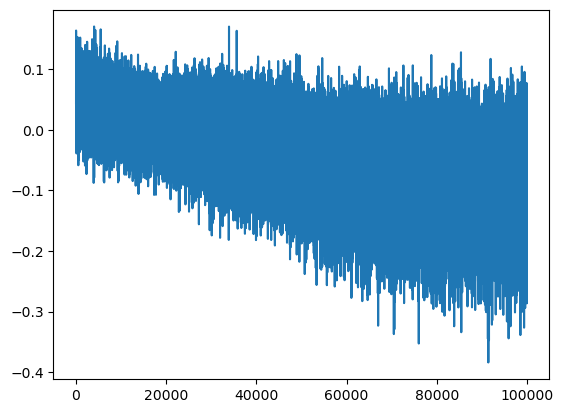

In [135]:
plt.plot(lossi)

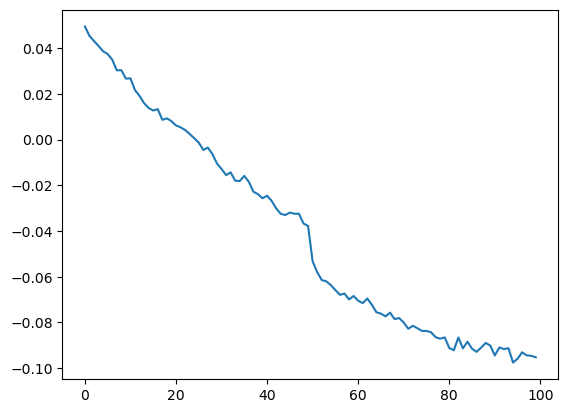

In [136]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [137]:
PATH = "../src/model/trained_models/wavenet.pt"
# model.eval()
# torch.save(model.state_dict(), PATH)
torch.save(model, PATH)

In [143]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [Xtr, Ytr],
        'val'  : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    
    x = x[:, None, :]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [145]:
model.train()
split_loss('train')
split_loss('val')

train 0.797700047492981
val 0.8445966243743896


In [146]:
@torch.no_grad()
def accuracy(split):
    x, y = {
        'train': [Xtr, Ytr],
        'val'  : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.argmax(logits, dim=1)

    i = 0
    for pred, true in zip(preds, y):
        if pred == true:
            i += 1
    
    print(f"----{split}----")
    print(f"Correctly predicted {i} out of {y.shape[0]} in {split}.")
    print(f"{i / y.shape[0]:.4f}")
    print(f"Guessing would give an accuracy of {1 / len(torch.unique(y))}")

In [147]:
accuracy('train')
accuracy('val')

----train----
Correctly predicted 40041 out of 63932 in train.
0.6263
Guessing would give an accuracy of 0.3333333333333333
----val----
Correctly predicted 4740 out of 7992 in val.
0.5931
Guessing would give an accuracy of 0.3333333333333333
